## Part 1: Data Splitting & "Anti-Leakage" Setup (Crucial)
Data leakage occurs when information from outside the training data—especially from the test set or future data—accidentally influences the model during training, leading to unrealistically high performance.

It is prevented by splitting data before any analysis, performing all preprocessing and feature engineering inside pipelines, using cross-validation correctly, and keeping the test set completely unseen until final evaluation.

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

#### Loading and inspecting the dataset

In [209]:
df = pd.read_csv('Downloads/Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [211]:
df.shape

(10000, 14)

In [212]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Splitting the data
We first separate the dataset into features (X) and target (y). The data is then split into 80% training and 20% testing, ensuring that the test set remains completely unseen during model development. <br>Stratify=y preserves the same proportion of churned vs. non-churned customers in both sets, while random_state=42 ensures the split is reproducible. <br>All feature engineering, analysis, and model training are performed only on the training set to prevent data leakage and guarantee a fair evaluation on the test set.

In [213]:
X = df.drop(columns='Exited')
y=df['Exited']

RANDOM_SEED = 42
X_train,X_test,y_train,y_test = train_test_split(
    X, y, 
    test_size = 0.2, 
    random_state=RANDOM_SEED, 
    stratify=y
)

## Part 2: Feature Engineering & Preprocessing

#### Dropping Useless Columns
Columns like RowNumber, CustomerId, and Surname are unique identifiers or irrelevant to churn prediction. Keeping them would not help the model learn patterns and could introduce noise, so we drop them to focus on meaningful features.

In [214]:
#drop useless columns
drop_features = ['RowNumber','CustomerId','Surname']

#### Feature Engineering
This class creates new meaningful features and removes irrelevant ones. <br>First, it drops useless columns like RowNumber, CustomerId, and Surname to avoid noise. <br>Then, it derives four new features:

- Balance_per_Product : measures average balance per product, giving insight into customer value.

- Age_per_Tenure : shows how experienced the customer is relative to their age.

- Salary_per_Product : indicates how salary relates to number of products held.

- Balance_to_Salary_Ratio : reflects financial burden vs. income.

Creating these derived features can help tree-based models capture patterns more effectively and improve prediction accuracy.

In [215]:
#custom feature selection
class DerivedFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X = X.drop(drop_features, axis=1, errors='ignore')
        
        X["Balance_per_Product"] = X["Balance"] / (X["NumOfProducts"] + 1e-6)
        X['Age_per_Tenure'] = X['Age'] / (X['Tenure'] + 1e-6)
        X['Salary_per_Product'] = X['EstimatedSalary'] / (X['NumOfProducts'] + 1e-6)
        X['Balance_to_Salary_Ratio'] = X['Balance'] / (X['EstimatedSalary'] + 1e-6)
        return X

In [216]:
#checking datatypes for columns in input features
X.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

### Feature Types
We separate features based on their type to apply appropriate preprocessing.

- Numeric features like CreditScore, Balance, etc., will be scaled.

- Categorical features like Geography will be one-hot encoded.

- Binary features like Gender will be encoded as 0/1.

In [217]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_features = ['Geography']
binary_features = ['Gender']

**Numeric Transformer:**<br>
Fills missing values with the median (SimpleImputer) and scales features (StandardScaler) for uniformity.

In [218]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

**Categorical Transformer:**<br> Fills missing values with the most frequent category and applies one-hot encoding (OneHotEncoder) to convert categories into numeric format.

In [219]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

**Binary Transformer:**<br> Handles binary features by filling missing values and encoding them as 0/1 for model compatibility.

In [220]:
binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="if_binary"))
])


We use a ColumnTransformer to apply different preprocessing steps to different types of features in one unified pipeline.<br> Numeric features are imputed and scaled, categorical features are imputed and one-hot encoded, and binary features are imputed and encoded as 0/1.<br> This ensures that all features are properly transformed and ready for the model, keeping the preprocessing consistent and preventing errors or data leakage.

In [221]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features)
    ]
)

## Part 3: Model Development (Tree-Based Models)

### Baseline Model (Dummy Classifier) 

We create a baseline model using DummyClassifier with the most_frequent strategy, which always predicts the class that occurs most often in the training set. <br>The pipeline first applies derived feature creation and preprocessing so that the data is in the same format as it would be for real models.<br> Fitting this dummy model and evaluating on the test set gives a dummy accuracy of 0.7965, which represents the performance of a model with no learning.<br> This baseline is important because it shows the minimum performance any real model should exceed; if your advanced models don’t do better than this, they aren’t actually learning useful patterns from the data.

In [222]:
dummy_pipeline = Pipeline(steps=[
    ("derived_features", DerivedFeatures()),
    ("preprocess", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent"))
])

In [223]:
dummy_pipeline.fit(X_train, y_train)
dummy_preds = dummy_pipeline.predict(X_test)

print("Dummy Accuracy:", accuracy_score(y_test, dummy_preds))

Dummy Accuracy: 0.7965


### Decision Tree Model

We train a Decision Tree to model customer churn by learning hierarchical decision rules from the features. <br>The pipeline first creates derived features and applies preprocessing, then fits a tree-based classifier. <br>The tree captures non-linear relationships between features and the target, and we can visualize it to interpret which features influence churn.<br> Decision Trees are simple, fast, and help us understand feature importance, but they may overfit if not properly constrained.

In [224]:
#decision tree pipeline
dt_pipeline = Pipeline([
    ("derived_features", DerivedFeatures()),
    ("preprocess", preprocessor),
    ("dt_model", DecisionTreeClassifier(
        max_depth=3,
        random_state=RANDOM_SEED
    ))
])

dt_pipeline.fit(X_train, y_train)

,steps,"[('derived_features', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We visualize the trained Decision Tree to see how it splits features and makes decisions for predicting churn.

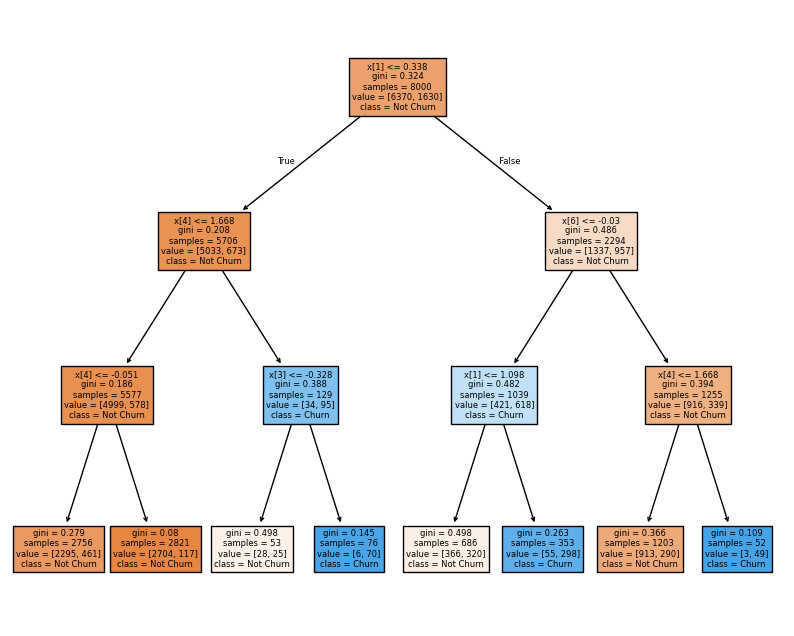

In [225]:
#visualise decision tree
plt.figure(figsize=(10,8))

plot_tree(
    dt_pipeline.named_steps["dt_model"],
    filled=True,
    feature_names=None,
    class_names=["Not Churn", "Churn"]
)

plt.show()

### Random Forest Model
The Random Forest builds an ensemble of many Decision Trees, each trained on random subsets of data and features.<br> The final prediction is the majority vote from all trees. <br>This approach reduces overfitting compared to a single tree and usually achieves higher accuracy. <bR>Using the pipeline ensures consistent preprocessing and feature engineering. <br>Random Forests are robust and handle non-linear interactions well, making them strong models for churn prediction.

In [226]:
rf_pipeline = Pipeline(steps=[
    ("derived_features", DerivedFeatures()),
    ("preprocess", preprocessor),
    ("rf_model", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=RANDOM_SEED,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train,y_train)


,steps,"[('derived_features', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### XGBoost Model(Gradient Boosting)
XGBoost is a gradient boosting model that builds trees sequentially, where each new tree corrects errors from the previous ones.<br> The pipeline ensures all preprocessing steps are applied consistently.<br> XGBoost often achieves the best performance because it optimizes predictions iteratively and handles feature interactions efficiently. <br>It’s highly accurate for tabular data like customer churn and also provides feature importance scores to identify key drivers of churn.

In [227]:
xgb_pipeline = Pipeline(steps=[
    ("derived_features", DerivedFeatures()),
    ("preprocess", preprocessor),
    ("xgb_model", xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_SEED,
        eval_metric="logloss"
    ))
])

xgb_pipeline.fit(X_train,y_train)

,steps,"[('derived_features', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Part 4: Hyperparameter Tuning & Cross-Validation


#### Cross-Validation
Cross-validation is used to evaluate how well a model generalizes to unseen data by repeatedly training and validating it on different subsets of the training data. 

In K-Fold Cross-Validation, the training dataset is divided into K equal-sized folds (here, K = 5). <br>The model is trained on K−1 folds and validated on the remaining fold, and this process is repeated until each fold has been used once for validation. 

In this code, cross_val_score performs 5-fold cross-validation on the Random Forest pipeline using ROC-AUC as the evaluation metric. <br>This results in multiple ROC-AUC scores, one from each fold. Averaging these scores provides a stable and reliable estimate of model performance, reduces bias from a single train–test split, and helps detect overfitting before final evaluation on the test set.

In [228]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation using ROC-AUC
cv_scores = cross_val_score(
    rf_pipeline,        
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print("Cross-validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())

Cross-validation ROC-AUC scores: [0.86064855 0.86604916 0.84715307 0.86776348 0.87292331]
Mean ROC-AUC: 0.8629075131704405


#### Hyperparameter Tuning
Hyperparameter tuning is the process of optimizing a model’s settings using cross-validation to improve performance while reducing overfitting and ensuring better generalization to unseen data.

We define a hyperparameter grid for XGBoost to tune the hyperparameters using GridSearchCV for optimal performance.<br>
- n_estimators: The number of trees the model will build. More trees can improve learning but may increase training time and risk overfitting.

- max_depth: The maximum depth of each tree. Deeper trees can capture more complex patterns but may overfit the training data.

- learning_rate: Controls how much each new tree contributes to correcting previous errors. Smaller values make learning slower but more stable, often improving generalization.

These hyperparameters are tuned to balance accuracy and overfitting, ensuring the model performs well on unseen data.

In [229]:
param_grid = {
    "xgb_model__n_estimators": [100, 200],
    "xgb_model__max_depth": [3, 5, 7],
    "xgb_model__learning_rate": [0.05, 0.1]
}

In [230]:
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("The best hyperparameters: ",grid_search.best_params_)

The best hyperparameters:  {'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 3, 'xgb_model__n_estimators': 200}


## Part 5: Final Evaluation & Business Insights

To evaluate multiple classification models (Dummy, Decision Tree, Random Forest, XGBoost) by calculating key metrics on the test data, storing results in a dictionary, and displaying them as a DataFrame for easy comparison.

These metrics capture different aspects of prediction quality:

- Accuracy: Measures the overall proportion of correct predictions, giving a general sense of model performance.

- Precision: Shows how many of the predicted churn cases are actually true churns, helping assess false positives.

- Recall: Indicates how many of the actual churn cases the model successfully identified, focusing on false negatives.

- F1-Score: Combines precision and recall into a single metric, providing a balance between over- and under-prediction.

- ROC-AUC: Evaluates the model’s ability to distinguish between churn and non-churn across all classification thresholds.

### Train vs Test Performance Comparison

To ensure the model generalizes well and does not overfit, we compare its performance on both the training and test datasets. Similar performance across both datasets indicates that the model has learned meaningful patterns rather than memorizing the data.


In [238]:
from sklearn.metrics import roc_auc_score

# Train performance
train_prob = best_model.predict_proba(X_train)[:, 1]
test_prob = best_model.predict_proba(X_test)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_prob))
print("Test ROC-AUC:", roc_auc_score(y_test, test_prob))

Train ROC-AUC: 0.8997461740713275
Test ROC-AUC: 0.8669162228484263


In [240]:
# Dictionary to store metrics
results = {}

for name, model in [("Dummy", dummy_pipeline), 
                    ("Decision Tree", dt_pipeline), 
                    ("Random Forest", rf_pipeline), 
                    ("XGBoost", xgb_pipeline)]:
    
    y_pred = model.predict(X_test)
    
    # For ROC-AUC, get probabilities for positive class
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

# Convert to DataFrame for better display
results_df = pd.DataFrame(results).T
results_df

/opt/homebrew/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Dummy,0.7965,0.000000,0.000000,0.000000,0.500000
Decision Tree,0.8380,0.873874,0.238329,0.374517,0.795413
Random Forest,0.8675,0.819820,0.447174,0.578696,0.863461
XGBoost,0.8705,0.796000,0.488943,0.605784,0.864566


### Plotting ROC Curve
This code plots the ROC curves of the Decision Tree, Random Forest, and XGBoost models on the test set. For each model, it computes the predicted probabilities for the positive class (Churn), calculates the False Positive Rate (FPR) and True Positive Rate (TPR), and plots them. The diagonal line represents a random classifier for reference. By comparing these curves, we can visually assess which model better distinguishes between churn and non-churn customers—the closer the curve is to the top-left corner, the better the model.

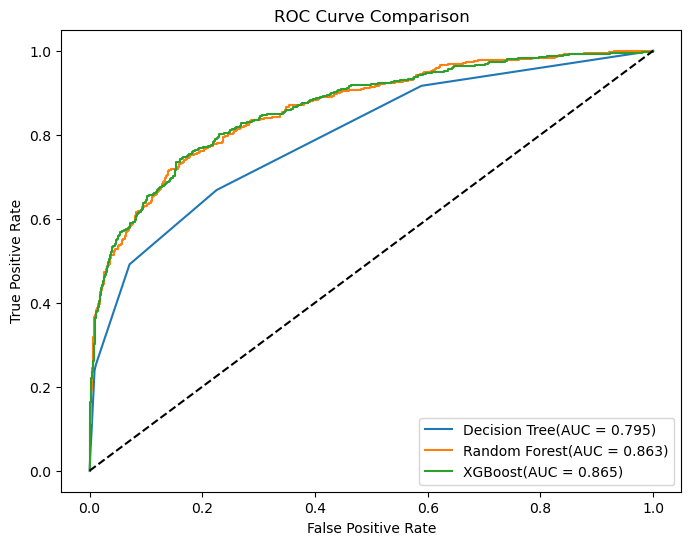

In [232]:
plt.figure(figsize=(8,6))

for name, model in [("Decision Tree", dt_pipeline), 
                    ("Random Forest", rf_pipeline), 
                    ("XGBoost", xgb_pipeline)]:
    
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name}(AUC = {auc_score:.3f})")

plt.plot([0,1],[0,1], 'k--')  # diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### Evaluate the best model on the Test Set
We evaluate the best model (selected via GridSearchCV) on the test set by calculating key metrics—Accuracy, Precision, Recall, F1-Score, and ROC-AUC—to measure its overall performance and ability to correctly predict churn.

In [233]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [234]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.867
Precision: 0.7854251012145749
Recall: 0.47665847665847666
F1 Score: 0.5932721712538226
ROC AUC: 0.8669162228484263


### Plot a Confusion Matrix
A confusion matrix is a table that compares predicted labels with actual labels in classification problems.

It shows four outcomes:

- True Positives (TP): Correctly predicted churn cases.

- True Negatives (TN): Correctly predicted non-churn cases.

- False Positives (FP): Predicted churn but actually non-churn.

- False Negatives (FN): Predicted non-churn but actually churn.

This helps us understand not just how accurate the model is overall, but also how well it identifies churn vs. non-churn customers.
Especially in imbalanced datasets, a model might have high accuracy but still miss many churners.

The confusion matrix is also the foundation for metrics like Precision, Recall, and F1-Score, giving a more detailed view of model performance.

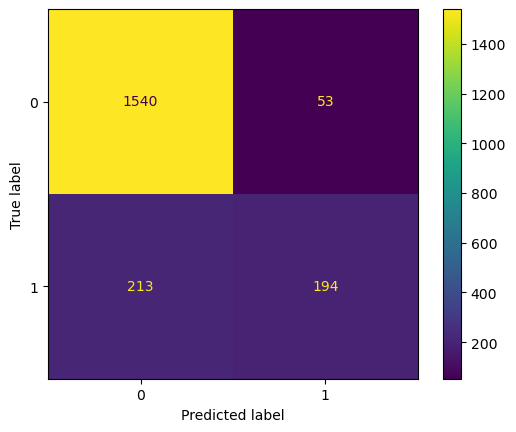

In [235]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

**False Negatives (Missed Churners):**  
These are customers who actually churned but were predicted to stay. They are particularly costly since no retention action would be taken.

**False Positives (False Alarms):**  
These customers were predicted to churn but did not. While they may incur unnecessary retention costs, they are less harmful than false negatives.

**Misclassified Customers:**  
Misclassifications often involve moderately engaged customers or those near decision boundaries, highlighting that churn behavior can be complex and influenced by external factors.


### Feature Importance Plot
Feature Importance tells us which input features the model relied on most to make predictions. In tree-based models like Random Forest or XGBoost, it measures how much each feature reduces uncertainty or improves splits across all trees. Features with higher importance values have a bigger impact on predicting churn. Visualizing feature importance helps us:
- Understand key drivers of customer churn (e.g., Balance, Age, Tenure).

- Make business decisions to reduce churn, like targeting specific customer segments.

- Simplify models by potentially removing less important features without losing performance.

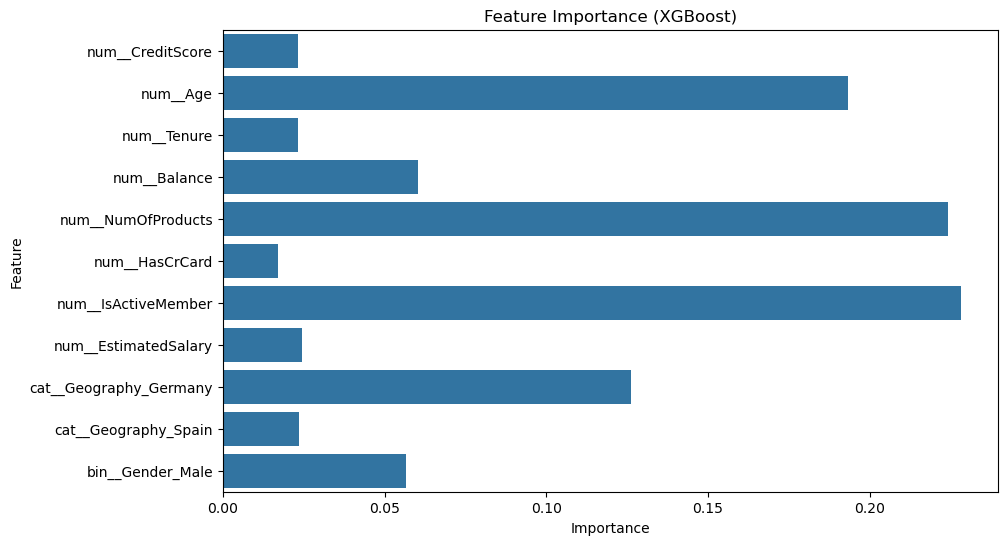

In [236]:
importances = best_model.named_steps["xgb_model"].feature_importances_
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances,
    y=feature_names
)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Business Insights

Some clear, business-focused insights derived directly from the model’s behavior and feature importance:

- Customer engagement is critical: Inactive customers have a significantly higher risk of churn, indicating that regular interaction and usage play a key role in retention.

- Product holding strengthens loyalty: Customers with only one product are more likely to leave, while those with multiple products show stronger commitment to the bank.

- High balance alone does not ensure retention: Customers with high balances but low engagement are still at risk, suggesting dissatisfaction or better competing offers.

- Early-life customers need attention: Customers with shorter tenure relative to age show higher churn risk, emphasizing the importance of onboarding and early engagement.

- Targeted retention can be effective: By focusing retention efforts on inactive, single-product customers, the bank can reduce churn while maximizing return on marketing spend.

### Deeper Business Insights

Beyond model performance, exploratory analysis was conducted to identify customer segments with higher churn risk.


**Churn by Geography**<br>
Customers in Germany are more likely to leave the bank (~32%) than customers in France and Spain (~16%), suggesting possible regional dissatisfaction or stronger competition.

In [243]:
df.groupby("Geography")["Exited"].mean()

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64

**Churn by Number of Products**<br>
Customers with only one product are much more likely to leave (~28%), while customers with two products are more loyal, and the very high churn for 3–4 products is likely due to very few such customers in the data.

In [244]:
df.groupby("NumOfProducts")["Exited"].mean()

NumOfProducts
1    0.277144
2    0.075817
3    0.827068
4    1.000000
Name: Exited, dtype: float64

**Churn by Activity Status**<br>
Inactive customers churn almost twice as much (~27%) as active customers (~14%), confirming customer engagement as a key retention driver.

In [245]:
df.groupby("IsActiveMember")["Exited"].mean()

IsActiveMember
0    0.268509
1    0.142691
Name: Exited, dtype: float64

## Conclusion 

#### Why the model is better than the baseline?
The final model significantly outperforms the baseline Dummy Classifier, which only predicts the majority class and fails to learn meaningful patterns. In contrast, the trained model (XGBoost) captures complex relationships between customer behavior and churn, resulting in much higher ROC-AUC and F1-Score. Feature importance analysis shows that customers with high account balance, low number of products, low activity levels, and certain geographic locations are most likely to leave. This allows the bank to proactively target high-risk customer segments with personalized retention strategies.

#### Which customer segment is most likely to leave?
Based on the feature importance results from the best-performing model (Random Forest), customers most likely to churn are those who are **not active members** and hold only a small number of bank products. The high importance of IsActiveMember shows that disengaged customers are significantly more prone to leaving the bank. 

Similarly, the strong influence of **NumOfProducts** indicates that customers with just one product lack strong ties to the bank and are therefore at higher churn risk.

In addition, derived features such as Balance_per_Product and Balance_to_Salary_Ratio suggest that customers with high balances but low engagement are more likely to churn, possibly due to dissatisfaction or better alternatives elsewhere. Overall, the model clearly identifies low engagement and weak product relationship as the primary churn drivers, making inactive, single-product customers the most vulnerable segment.

**Conculding, this end-to-end churn prediction pipeline demonstrates strong predictive performance, robust validation, and clear business interpretability. By combining proper anti-leakage practices, advanced ensemble models, explainability techniques, and business-driven insights, the solution enables effective identification of high-risk customers and supports data-driven retention strategies.**
